In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import lag_plot
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.diagnostic as diag
from scipy.stats import jarque_bera

In [30]:
import pandas as pd

# Load data from a JSON file
data = pd.read_json('C:/Users/yunit/Downloads/csvjson.json')

# Remove unnecessary columns
data = data[data['id_gh'] == 1]
data = data.drop(columns=['id', 'soil', 'id_gh'])

# Set timestamp as the index and ensure it is parsed as datetime
data['time'] = pd.to_datetime(data['time'], errors='coerce')  # Convert to datetime
data = data.dropna(subset=['time'])  # Drop rows with invalid datetime
data = data.set_index('time')

# Mengubah nama kolom 'moist' menjadi 'humid'
data.rename(columns={'moist': 'humid'}, inplace=True)

# Resample the data to hourly intervals, taking the first sample from each hour
data = data.resample('H').first()

# Pembagian Data
train_size = int(len(data) * 0.8)  # 80% untuk training
train_data = data[:train_size]
test_data = data[train_size:]

# Display the first few rows of the resampled data
data

,lumen,humid,temp
time,,,
2024-08-09 08:00:00+00:00,2178,61,28
2024-08-09 09:00:00+00:00,2235,66,26
2024-08-09 10:00:00+00:00,399,70,25
2024-08-09 11:00:00+00:00,6,75,24
2024-08-09 12:00:00+00:00,6,77,23
...,...,...,...
2024-08-22 23:00:00+00:00,331,79,22
2024-08-23 00:00:00+00:00,1762,71,25
2024-08-23 01:00:00+00:00,3610,55,29


### time series plot

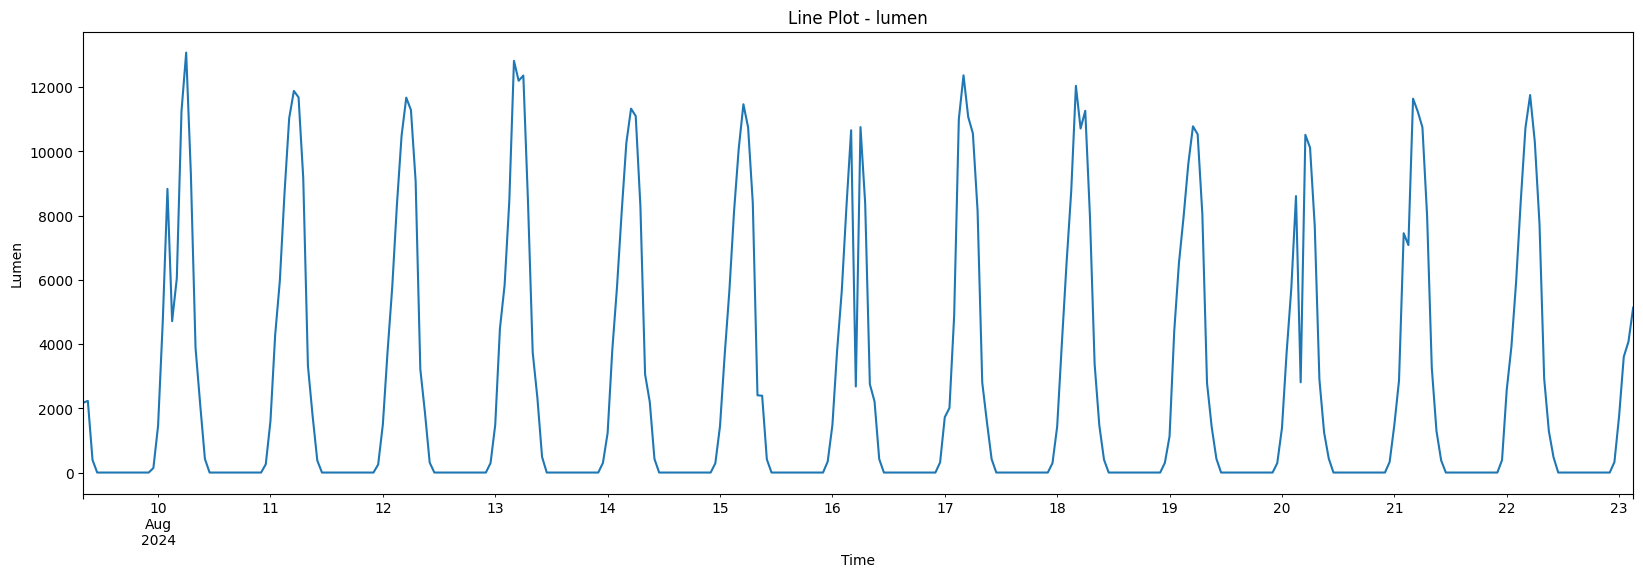

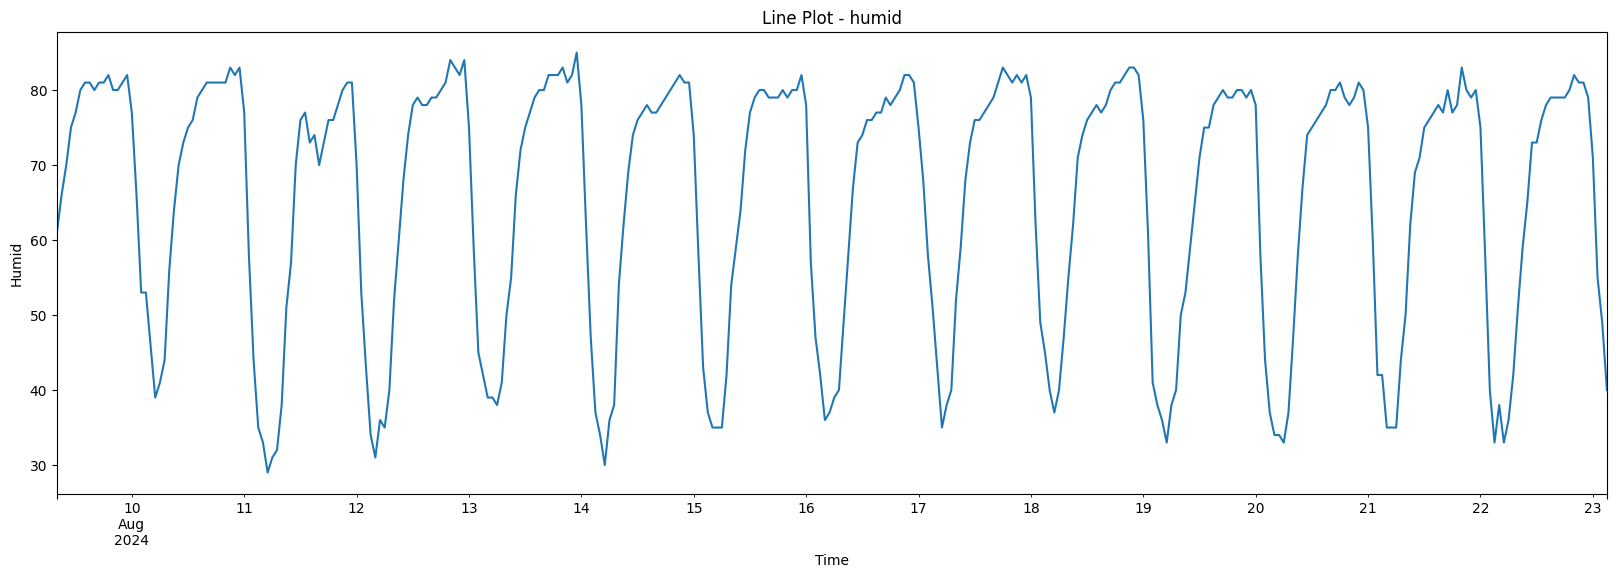

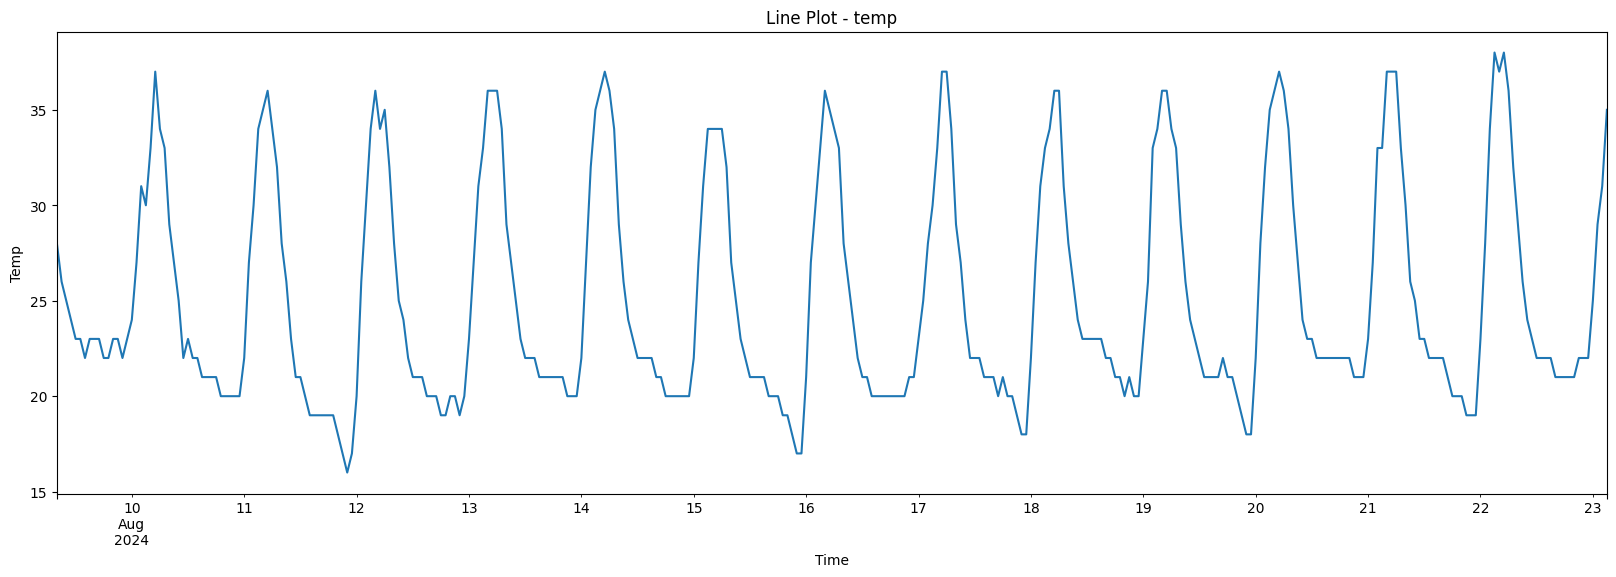

In [3]:
# histogram
for column in data.columns:
    plt.figure(figsize=(20, 6))
    data[column].plot()
    plt.title(f'Line Plot - {column}')
    plt.ylabel(column.capitalize())
    plt.xlabel('Time')
    plt.show()

### uji stasioneritas data

In [4]:
# Kolom-kolom yang akan diuji
series = ['lumen', 'humid', 'temp']

# Inisialisasi daftar untuk menyimpan hasil
results = []

# Loop melalui setiap kolom dan lakukan uji ADF
for column in series:
    subset = data[column].dropna()  # Menghapus nilai NaN untuk memastikan validitas uji
    if not subset.empty:
        try:
            adf_result = adfuller(subset)
            p_value = adf_result[1]  # Ekstrak p-value
        except Exception as e:
            p_value = None
            print(f"Error performing ADF test on column '{column}': {e}")
    else:
        p_value = None  # Jika subset kosong setelah menghapus NaN

    # Tambahkan hasil ke daftar
    results.append({'Series': column, 'p-value': p_value})

# Konversi daftar hasil menjadi DataFrame
results_df = pd.DataFrame(results)

# Tampilkan tabel p-value
print('Tabel p-value ADF test')
print(results_df)

Tabel p-value ADF test
  Series       p-value
0  lumen  8.770153e-27
1  humid  3.201865e-10
2   temp  1.165462e-08


## Model VAR dataset asli

In [5]:
model = VAR(train_data)
results = model.fit(maxlags= 3)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 25, Aug, 2024
Time:                     21:10:18
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    16.9751
Nobs:                     262.000    HQIC:                   16.7308
Log likelihood:          -3255.50    FPE:                1.56605e+07
AIC:                      16.5665    Det(Omega_mle):     1.39960e+07
--------------------------------------------------------------------
Results for equation lumen
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const         3234.213128      2859.467271            1.131           0.258
L1.lumen         0.506067         0.073551            6.881           0.000
L1.humid       -15.200369        37.820275           -0.402           0.688
L1.t

### evaluasi model

In [6]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Prediksi menggunakan data terakhir
lag_order = results.k_ar
input_data = test_data.values[-lag_order:]
forecast = results.forecast(input_data, steps=len(test_data))
forecast_df = pd.DataFrame(forecast, index=test_data.index[-len(forecast):], columns=test_data.columns)

# Hitung R²
r2_scores = {column: r2_score(test_data[column][-len(forecast):], forecast_df[column]) for column in test_data.columns}

# Hitung MAE
mse_scores = {column: mean_squared_error(test_data[column][-len(forecast):], forecast_df[column]) for column in test_data.columns}

# Hitung MAE
mae_scores = {column: mean_absolute_error(test_data[column][-len(forecast):], forecast_df[column]) for column in test_data.columns}

# Hitung MAPE

mape_scores = {column: mean_absolute_percentage_error(test_data[column][-len(forecast):], forecast_df[column]) for column in test_data.columns}

print("R² scores:", r2_scores)
print("MSE scores:", mse_scores)
print("MAE scores:", mae_scores)
print("MAPE scores:", mape_scores)

R² scores: {'lumen': -0.10019873043719651, 'humid': 0.014824684641358332, 'temp': -0.08173448156279228}
MSE scores: {'lumen': 14074272.55014454, 'humid': 259.06840775621106, 'temp': 33.75040499414604}
MAE scores: {'lumen': 3019.0547381362653, 'humid': 13.655480060344983, 'temp': 4.661697917340507}
MAPE scores: {'lumen': 227.57984341720913, 'humid': 0.251456034047083, 'temp': 0.17721794268395175}


### uji residual

In [7]:
residuals = results.resid
# Inisialisasi dictionary untuk menyimpan hasil uji
jb_test_results = {}
lb_test_results = {}
arch_test_results = {}

# Lakukan uji untuk setiap kolom residual
for col in residuals.columns:
    print(f"Results for {col}:")

    # 1. Uji Normalitas Residual (Jarque-Bera Test)
    jb_stat, jb_pvalue = jarque_bera(residuals[col])
    jb_test_results[col] = (jb_stat, jb_pvalue)
    print(f"Jarque-Bera Test: JB-Statistic = {jb_stat:.4f}, p-value = {jb_pvalue:.4f}")
    
    # 2. Uji Autokorelasi Residual (Ljung-Box Test)
    lb_test = diag.acorr_ljungbox(residuals[col], lags=[10], return_df=True)
    lb_test_results[col] = lb_test
    print("Ljung-Box Test:")
    print(lb_test)
    
    # 3. Uji Heteroskedastisitas (ARCH Test)
    arch_test = diag.het_arch(residuals[col], nlags=10)
    arch_test_results[col] = arch_test
    print(f"ARCH Test: LM Statistic = {arch_test[0]:.4f}, p-value = {arch_test[1]:.4f}")
    
    print("\n")

Results for lumen:
Jarque-Bera Test: JB-Statistic = 917.7283, p-value = 0.0000
Ljung-Box Test:
      lb_stat  lb_pvalue
10  11.545206   0.316646
ARCH Test: LM Statistic = 28.9657, p-value = 0.0013


Results for humid:
Jarque-Bera Test: JB-Statistic = 47.7836, p-value = 0.0000
Ljung-Box Test:
     lb_stat  lb_pvalue
10  9.815999   0.456782
ARCH Test: LM Statistic = 16.2546, p-value = 0.0926


Results for temp:
Jarque-Bera Test: JB-Statistic = 11.4939, p-value = 0.0032
Ljung-Box Test:
      lb_stat  lb_pvalue
10  13.479994   0.198059
ARCH Test: LM Statistic = 28.3561, p-value = 0.0016




### forecast

Figure(1000x1000)


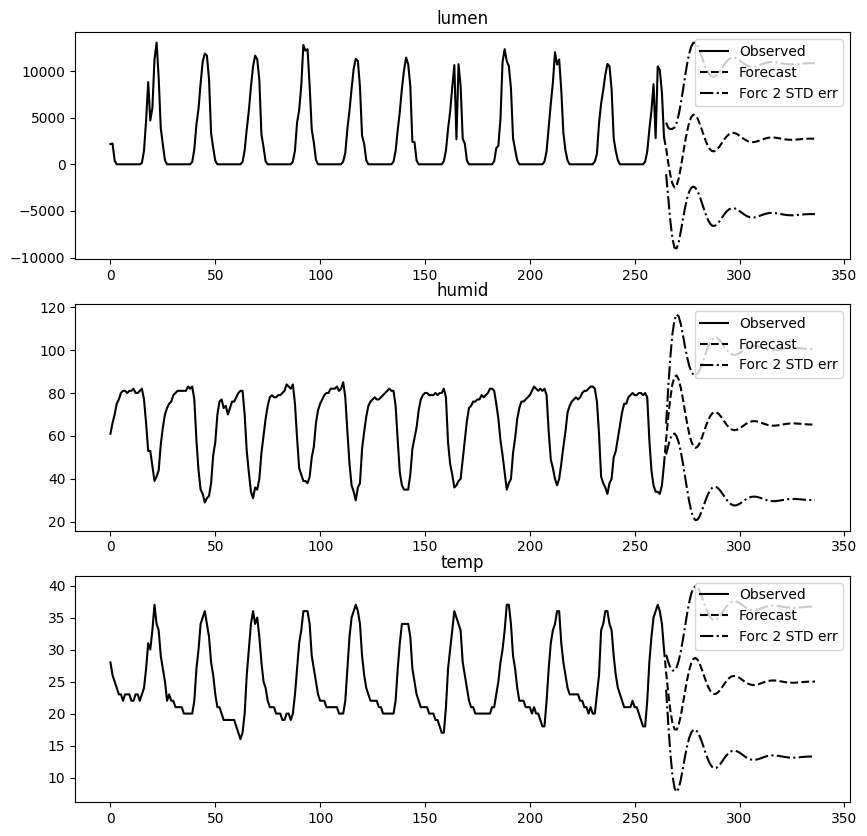

In [8]:
print(results.plot_forecast(72))

## Model VAR differencing

In [9]:
data_diff = np.log(data).diff().dropna()
model = VAR(data_diff)
results_diff = model.fit(maxlags= 3)
results_diff.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 25, Aug, 2024
Time:                     21:10:20
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -11.3269
Nobs:                     328.000    HQIC:                  -11.5354
Log likelihood:           548.269    FPE:                8.51438e-06
AIC:                     -11.6738    Det(Omega_mle):     7.78080e-06
--------------------------------------------------------------------
Results for equation lumen
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.015577         0.065018            0.240           0.811
L1.lumen         0.253516         0.057530            4.407           0.000
L1.humid        -2.802220         1.377131           -2.035           0.042
L1.t

### evaluasi model

In [10]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Prediksi menggunakan data terakhir
lag_order = results_diff.k_ar
input_data = data_diff.values[-lag_order:]
forecast = results_diff.forecast(input_data, steps=len(data_diff))
forecast_df = pd.DataFrame(forecast, index=data_diff.index[-len(forecast):], columns=data_diff.columns)

# Hitung R²
r2_scores = {column: r2_score(data_diff[column][-len(forecast):], forecast_df[column]) for column in data_diff.columns}

# Hitung MAE
mae_scores = {column: mean_absolute_error(data_diff[column][-len(forecast):], forecast_df[column]) for column in data_diff.columns}

# Hitung MAPE

mape_scores = {column: mean_absolute_percentage_error(data_diff[column][-len(forecast):], forecast_df[column]) for column in data_diff.columns}

print("R² scores:", r2_scores)
print("MAE scores:", mae_scores)
print("MAPE scores:", mape_scores)

R² scores: {'lumen': -0.014209756075455715, 'humid': -0.006001138800372008, 'temp': -0.005953077992388867}
MAE scores: {'lumen': 0.6785523622361895, 'humid': 0.07804746531071793, 'temp': 0.05686475895666847}
MAPE scores: {'lumen': 93472165220322.86, 'humid': 2541878326108.7725, 'temp': 4411574294506.672}


## Model triple exp smooting

### best parameter

In [11]:
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Fungsi untuk mencari parameter optimal untuk satu kolom
def find_best_params(series):
    best_params = {'alpha': None, 'beta': None, 'gamma': None}
    best_mse = np.inf

    for alpha in np.arange(0.1, 1.0, 0.1):
        for beta in np.arange(0.1, 1.0, 0.1):
            for gamma in np.arange(0.1, 1.0, 0.1):
                try:
                    model = ExponentialSmoothing(series, seasonal='add', seasonal_periods=12)
                    fit = model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
                    predictions = fit.fittedvalues
                    mse = mean_squared_error(series, predictions)
                    if mse < best_mse:
                        best_mse = mse
                        best_params = {'alpha': alpha, 'beta': beta, 'gamma': gamma}
                except Exception as e:
                    # Jika terjadi error, lewati kombinasi parameter ini
                    continue

    return best_params

# Menyimpan parameter optimal untuk setiap kolom
optimal_params = {}
for column in data.columns:
    best_params = find_best_params(train_data[column])
    optimal_params[column] = best_params

print("Optimal Parameters for each column:")
for column, params in optimal_params.items():
    print(f"{column}: {params}")

Optimal Parameters for each column:
lumen: {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.1}
humid: {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.1}
temp: {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.1}


### model & evaluation

In [31]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Parameter optimal
params = {
    'lumen': {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.1},
    'humid': {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.1},
    'temp': {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.1}
}

# Menyimpan hasil prediksi, residuals, dan metrik
results = {}
forecasts = {}
residuals = {}
r2_scores = {}
mse_scores = {}
mae_scores = {}
mape_scores = {}

for column in data.columns:
    # Fit model dengan data training
    fit = ExponentialSmoothing(
        train_data[column],
        seasonal_periods=24,  # Sesuaikan dengan periode musiman data Anda
        trend='add',
        seasonal='mul',
        initialization_method='estimated'
    ).fit(
        smoothing_level=params[column]['alpha'],
        smoothing_slope=params[column]['beta'],
        smoothing_seasonal=params[column]['gamma']
    )

    # Prediksi (in-sample fit) untuk data training
    train_predictions = fit.fittedvalues

    # Forecast (out-of-sample) untuk data test
    test_forecast = fit.forecast(steps=len(test_data))

    # Hitung residuals (data test - forecast)
    test_residuals = test_data[column] - test_forecast

    # Simpan hasil
    results[column] = {'model': fit, 'train_predictions': train_predictions, 'residuals': test_residuals}
    forecasts[column] = test_forecast
    residuals[column] = test_residuals
    
    # Hitung R², MSE, MAE, dan MAPE menggunakan data test dan prediksi
    r2_scores[column] = r2_score(test_data[column], test_forecast)
    mse_scores[column] = mean_squared_error(test_data[column], test_forecast)
    mae_scores[column] = mean_absolute_error(test_data[column], test_forecast)
    mape_scores[column] = mean_absolute_percentage_error(test_data[column], test_forecast) * 100

# Tampilkan hasil
print("R² scores:", r2_scores)
print("MSE scores:", mse_scores)
print("MAE scores:", mae_scores)
print("MAPE scores:", mape_scores)

import pickle

# Menyimpan model, prediksi, residuals, dan metrik evaluasi ke dalam file pickle
with open('model_replon.pkl', 'wb') as f:
    pickle.dump({
        'results': results,
        'forecasts': forecasts,
        'residuals': residuals,
        'r2_scores': r2_scores,
        'mse_scores': mse_scores,
        'mae_scores': mae_scores,
        'mape_scores': mape_scores
    }, f)

R² scores: {'lumen': 0.9176849304677184, 'humid': 0.4434833632326254, 'temp': 0.39442849063418983}
MSE scores: {'lumen': 1053014.0523985662, 'humid': 146.3454034317535, 'temp': 18.893992973659312}
MAE scores: {'lumen': 467.27399670399717, 'humid': 10.993086990524997, 'temp': 3.7426503349140976}
MAPE scores: {'lumen': 26.900507093967985, 'humid': 16.170940619134853, 'temp': 14.876216576571089}


C:\Users\yunit\AppData\Local\Temp\ipykernel_28460\310702900.py:29: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  ).fit(
C:\Users\yunit\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\yunit\AppData\Local\Temp\ipykernel_28460\310702900.py:29: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  ).fit(
C:\Users\yunit\AppData\Local\Temp\ipykernel_28460\310702900.py:29: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  ).fit(


### uji residual

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch, normal_ad

for column in data.columns:
    residuals = results[column]['residuals']
    
    # Jarque-Bera Test
    jb_stat, jb_pvalue = normal_ad(residuals)
    
    # Ljung-Box Test
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    lb_stat = lb_test['lb_stat'].values[0]  # Extract the test statistic
    lb_pvalue = lb_test['lb_pvalue'].values[0]  # Extract the p-value
    
    # Lakukan uji ARCH
    arch_test_results = het_arch(residuals)
    arch_stat = arch_test_results[0]
    arch_pvalue = arch_test_results[1]
   
    print(f"\nResults for {column}:")
    print(f"Jarque-Bera Test: JB-Statistic = {jb_stat:.4f}, p-value = {jb_pvalue:.4f}")
    print(f"Ljung-Box Test: LB-Statistic = {lb_stat:.4f}, p-value = {lb_pvalue:.4f}")
    print(f"ARCH Test: LM-Statistic = {arch_stat:.4f}, p-value = {arch_pvalue:.4f}")


Results for lumen:
Jarque-Bera Test: JB-Statistic = 10.2240, p-value = 0.0000
Ljung-Box Test: LB-Statistic = 55.4194, p-value = 0.0000
ARCH Test: LM-Statistic = 6.9902, p-value = 0.7264

Results for humid:
Jarque-Bera Test: JB-Statistic = 0.4275, p-value = 0.3039
Ljung-Box Test: LB-Statistic = 170.0258, p-value = 0.0000
ARCH Test: LM-Statistic = 46.4840, p-value = 0.0000

Results for temp:
Jarque-Bera Test: JB-Statistic = 0.4246, p-value = 0.3087
Ljung-Box Test: LB-Statistic = 225.3323, p-value = 0.0000
ARCH Test: LM-Statistic = 39.9700, p-value = 0.0000


### forecast

C:\Users\yunit\AppData\Local\Temp\ipykernel_28460\1299562132.py:20: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  ).fit(
C:\Users\yunit\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


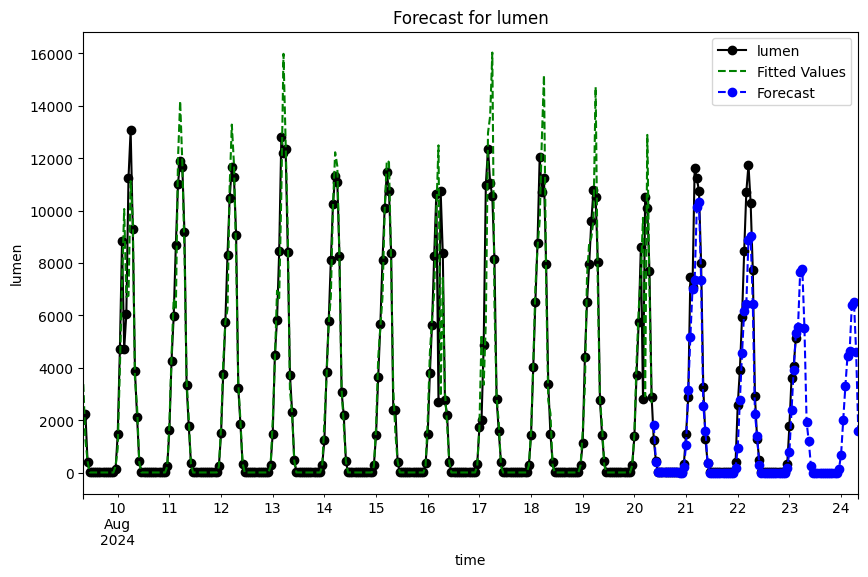

C:\Users\yunit\AppData\Local\Temp\ipykernel_28460\1299562132.py:20: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  ).fit(


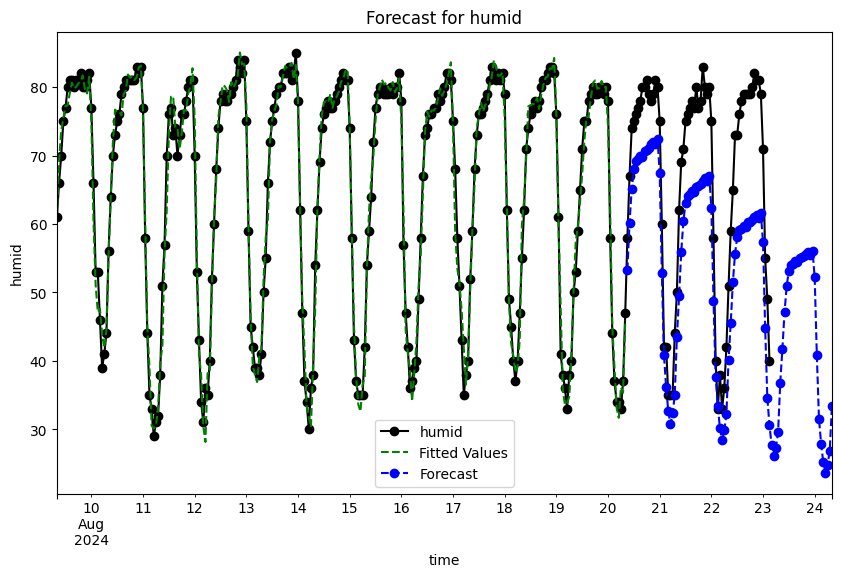

C:\Users\yunit\AppData\Local\Temp\ipykernel_28460\1299562132.py:20: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  ).fit(


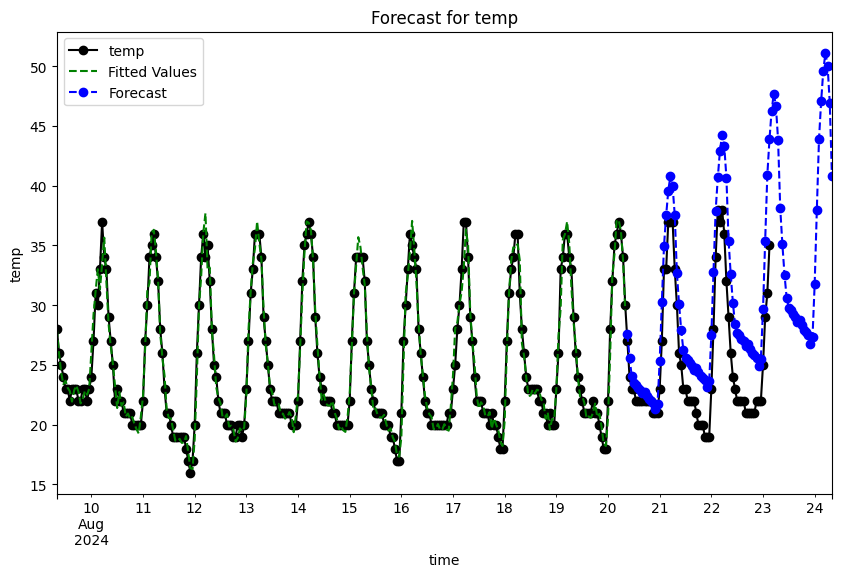

In [14]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Asumsi data sudah tersedia dalam variabel yang sesuai
columns = ['lumen', 'humid', 'temp']
params = {
    'lumen': {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.1},
    'humid': {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.1},
    'temp': {'alpha': 0.9, 'beta': 0.1, 'gamma': 0.1},
}

for column in columns:
    # Fit model
    model = ExponentialSmoothing(
        train_data[column],
        seasonal_periods=24,  # Sesuaikan dengan periode musiman data Anda
        trend='add',
        seasonal='mul',
        initialization_method='estimated'
    ).fit(
        smoothing_level=params[column]['alpha'],
        smoothing_slope=params[column]['beta'],
        smoothing_seasonal=params[column]['gamma']
    )
    
    # Plot actual data dan forecast
    plt.figure(figsize=(10, 6))
    data[column].plot(marker='o', color='black', title=f'Forecast for {column}')
    plt.ylabel(column)
    plt.xlabel('Time')
    
    # Plot fitted values
    model.fittedvalues.plot(style="--", color="green", label='Fitted Values')
    
    # Plot forecast
    forecast = model.forecast(steps=96)  # Anda bisa sesuaikan steps ini
    forecast.plot(style="--", marker="o", color="blue", label='Forecast')
    
    plt.legend()
    plt.show()


## Model single exp smooting

C:\Users\yunit\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


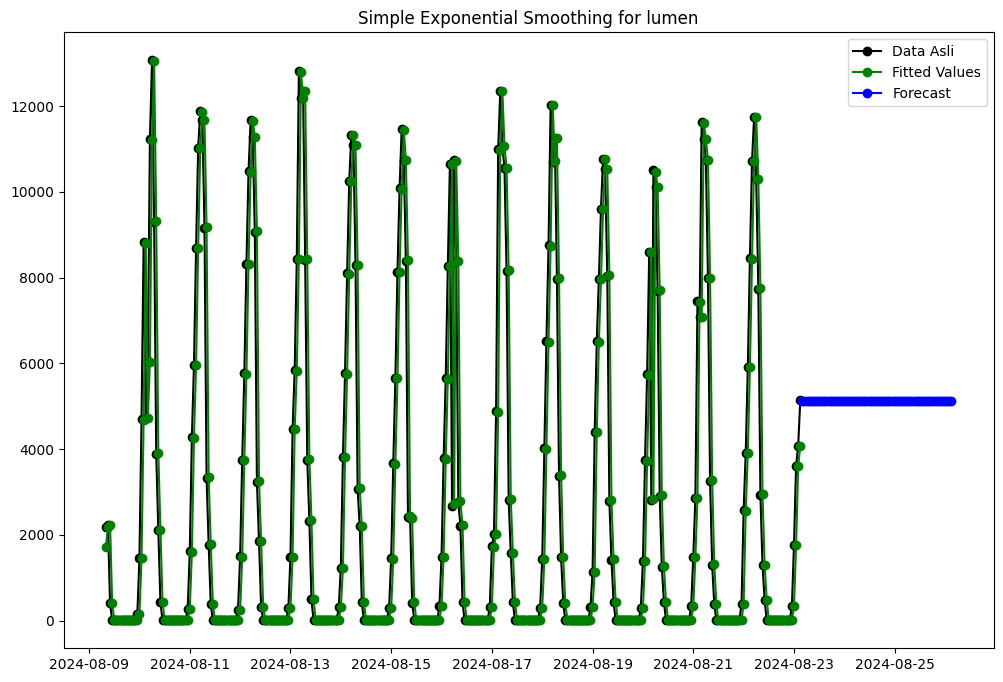

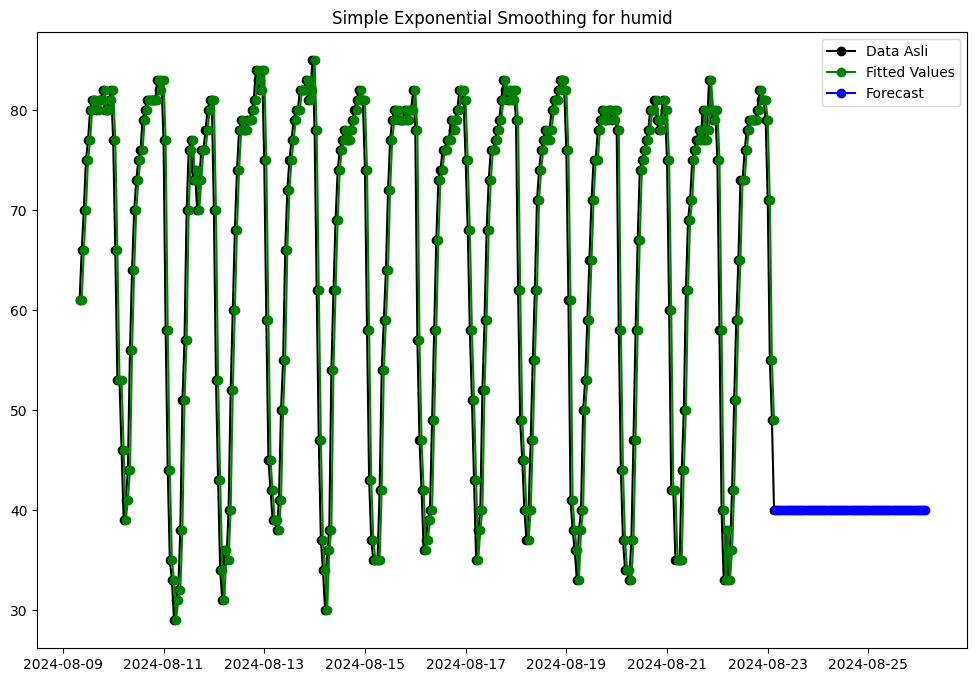

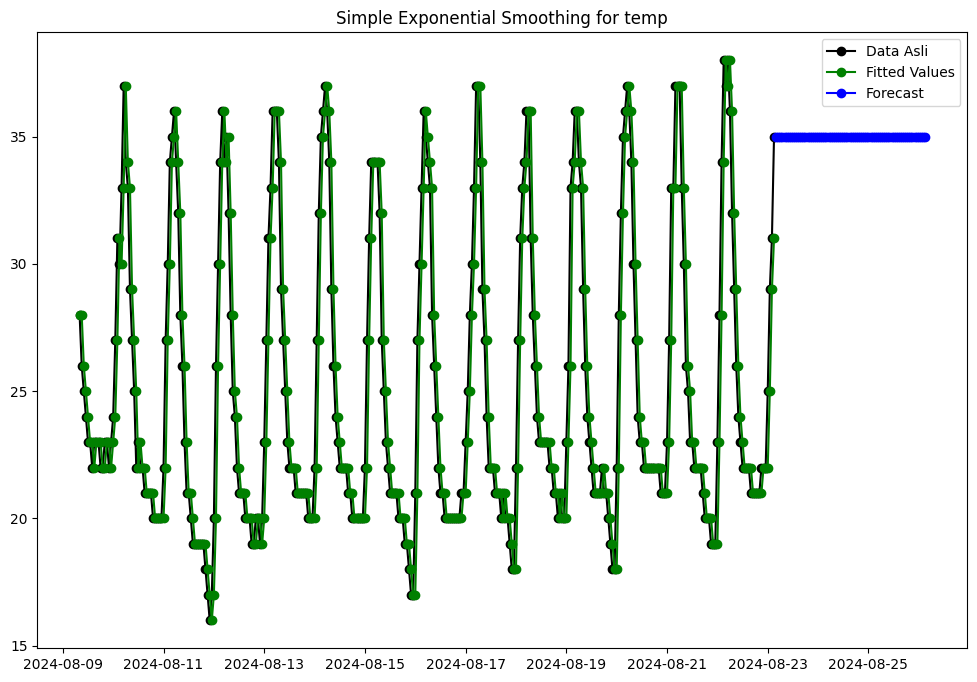

In [15]:
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing

for column in columns:
    ses = SimpleExpSmoothing(data[column], initialization_method="estimated").fit()
    forecast = ses.forecast(72).rename(r"$\alpha=%s$" % ses.model.params["smoothing_level"])

    plt.figure(figsize=(12, 8))
    plt.plot(data[column], marker="o", color="black", label="Data Asli")
    plt.plot(ses.fittedvalues, marker="o", color="green", label="Fitted Values")
    plt.plot(forecast, marker="o", color="blue", label="Forecast")
    plt.legend()
    plt.title(f"Simple Exponential Smoothing for {column}")
    plt.show()


## Model LSTM

C:\Users\yunit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Evaluasi Model untuk Intensity:
R²: -0.323280288

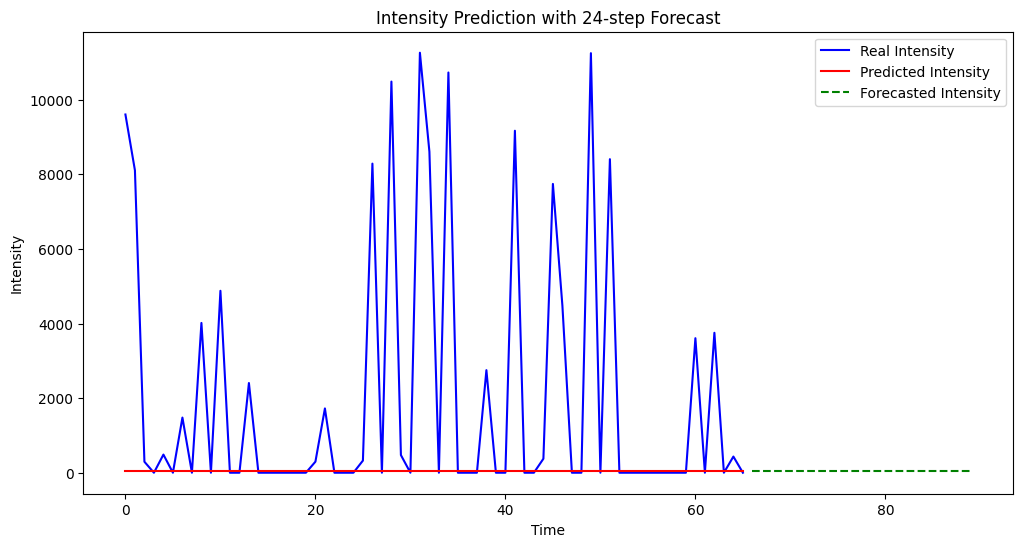

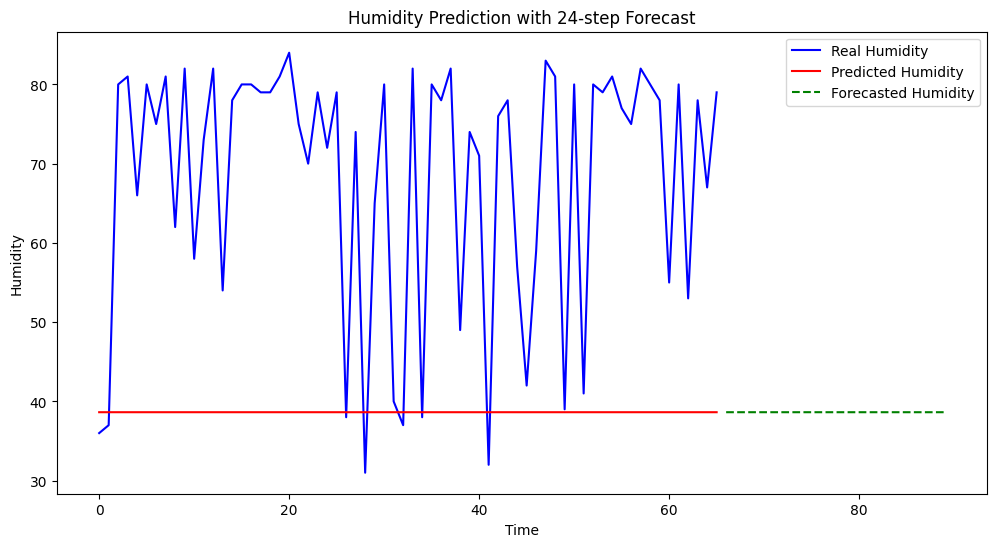

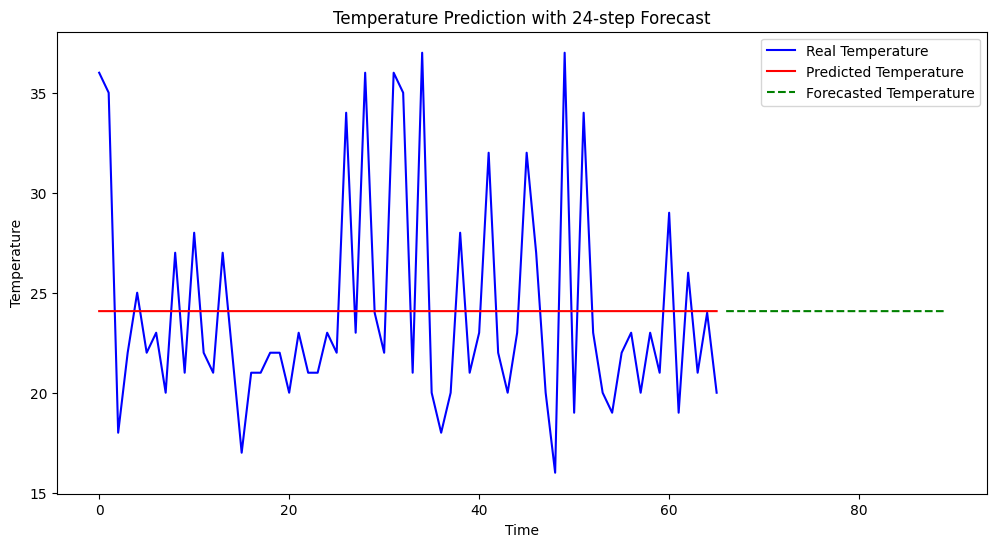

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Membentuk input untuk LSTM tanpa normalisasi
X = []
y = []
lookback = 5  # Panjang urutan yang dipakai untuk memprediksi

for i in range(lookback, len(data)):
    X.append(data.iloc[i-lookback:i, :].values)
    y.append(data.iloc[i, :].values)

X, y = np.array(X), np.array(y)

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Membentuk model LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=3))  # Output layer dengan 3 neurons, satu untuk setiap fitur

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model tanpa menampilkan epoch
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=0)

# Prediksi menggunakan model
predictions = model.predict(X_test)

# Membuat prediksi 24 langkah ke depan
forecast = []
last_sequence = X_test[-1]

for _ in range(24):
    next_pred = model.predict(last_sequence.reshape(1, lookback, 3))
    forecast.append(next_pred[0])
    last_sequence = np.vstack([last_sequence[1:], next_pred])

forecast = np.array(forecast)

# Evaluasi model
def evaluate_model(y_true, y_pred, variable_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"Evaluasi Model untuk {variable_name}:")
    print(f"R²: {r2}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}\n")

# Evaluasi untuk tiap variabel
evaluate_model(y_test[:, 0], predictions[:, 0], 'Intensity')
evaluate_model(y_test[:, 1], predictions[:, 1], 'Humidity')
evaluate_model(y_test[:, 2], predictions[:, 2], 'Temperature')

# Plot hasil prediksi vs data asli dengan 24 langkah ke depan
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], color='blue', label='Real Intensity')
plt.plot(predictions[:, 0], color='red', label='Predicted Intensity')
plt.plot(np.arange(len(y_test), len(y_test) + 24), forecast[:, 0], color='green', linestyle='--', label='Forecasted Intensity')
plt.title('Intensity Prediction with 24-step Forecast')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

# Plotting for humidity and temperature similarly
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 1], color='blue', label='Real Humidity')
plt.plot(predictions[:, 1], color='red', label='Predicted Humidity')
plt.plot(np.arange(len(y_test), len(y_test) + 24), forecast[:, 1], color='green', linestyle='--', label='Forecasted Humidity')
plt.title('Humidity Prediction with 24-step Forecast')
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 2], color='blue', label='Real Temperature')
plt.plot(predictions[:, 2], color='red', label='Predicted Temperature')
plt.plot(np.arange(len(y_test), len(y_test) + 24), forecast[:, 2], color='green', linestyle='--', label='Forecasted Temperature')
plt.title('Temperature Prediction with 24-step Forecast')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

## Model ARIMA


Results for lumen:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(4, 0, 3)   Log Likelihood               -2330.961
Date:                Sun, 25 Aug 2024   AIC                           4679.922
Time:                        21:12:16   BIC                           4712.139
Sample:                    08-09-2024   HQIC                          4692.866
                         - 08-20-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    727.8979     90.538      8.040      0.000     550.447     905.349
ar.L1          0.4231      0.079      5.383      0.000       0.269       0.577
ar.L2          0.7062      0.079

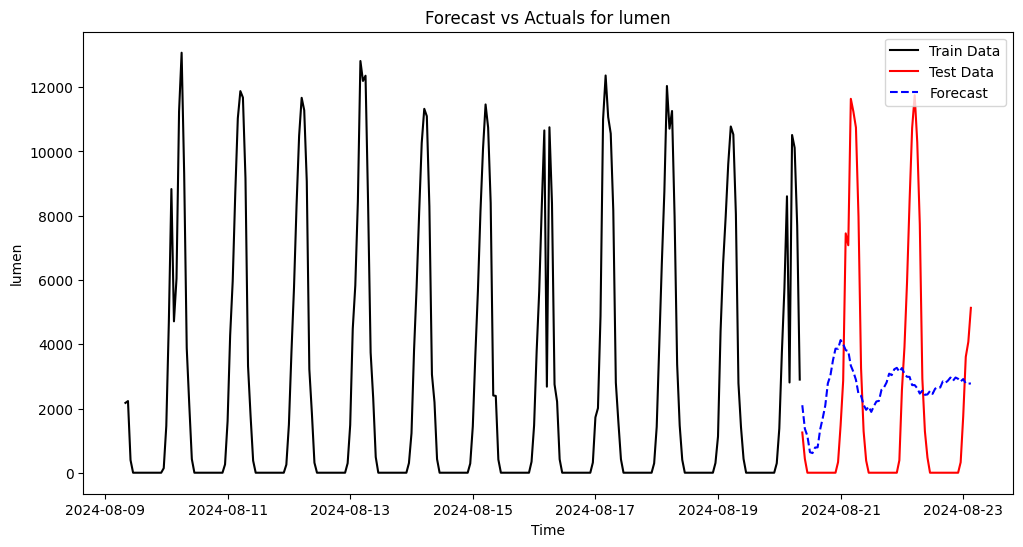


Results for humid:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -726.864
Date:                Sun, 25 Aug 2024   AIC                           1465.728
Time:                        21:12:22   BIC                           1487.206
Sample:                    08-09-2024   HQIC                          1474.357
                         - 08-20-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3675      0.485      4.879      0.000       1.416       3.319
ar.L1          2.3953      0.064     37.479      0.000       2.270       2.521
ar.L2         -1.9323      0.122

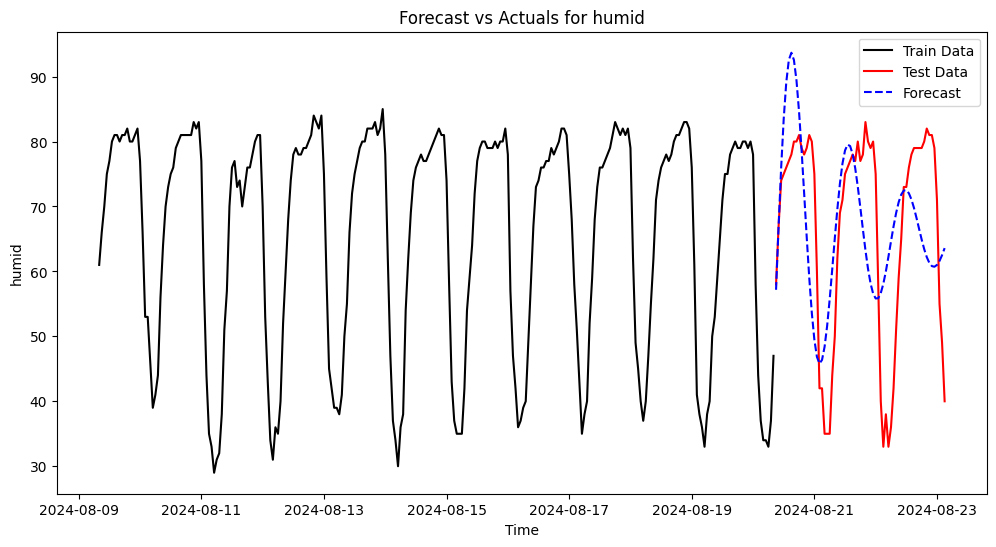


Results for temp:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -462.892
Date:                Sun, 25 Aug 2024   AIC                            937.784
Time:                        21:12:29   BIC                            959.263
Sample:                    08-09-2024   HQIC                           946.414
                         - 08-20-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.9666      0.183     10.768      0.000       1.609       2.325
ar.L1          1.8664      0.021     86.950      0.000       1.824       1.908
ar.L2         -0.9454      0.022 

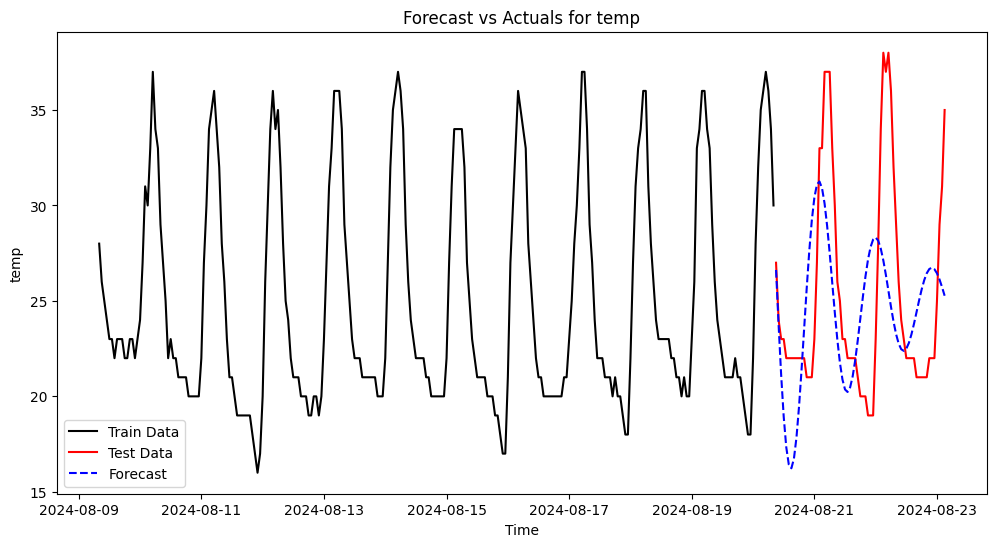


Overall Evaluation:
R² scores: {'lumen': 0.05719656455357636, 'humid': 0.16982616150865604, 'temp': 0.036635514607755604}
MSE scores: {'lumen': 12060796.058556287, 'humid': 218.30816418752838, 'temp': 30.057229470943856}
MAE scores: {'lumen': 2832.580904505244, 'humid': 12.345838928108996, 'temp': 4.541357452890077}
MAPE scores: {'lumen': 21589.43558056121, 'humid': 21.75575890606255, 'temp': 17.837026912973116}


In [17]:
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Asumsi data sudah tersedia dalam variabel yang sesuai
columns = ['lumen', 'humid', 'temp']  # Ganti dengan nama kolom Anda

# Menyimpan hasil evaluasi
r2_scores = {}
mse_scores = {}
mae_scores = {}
mape_scores = {}

for column in columns:
    # Fit model menggunakan auto_arima
    model = auto_arima(train_data[column], seasonal=False, stepwise=True)
    
    # Forecast pada data test
    forecast = model.predict(n_periods=len(test_data))
    
    # Hitung metrik evaluasi
    r2 = r2_score(test_data[column], forecast)
    mse = mean_squared_error(test_data[column], forecast)
    mae = mean_absolute_error(test_data[column], forecast)
    mape = mean_absolute_percentage_error(test_data[column], forecast) * 100

    # Simpan hasil evaluasi
    r2_scores[column] = r2
    mse_scores[column] = mse
    mae_scores[column] = mae
    mape_scores[column] = mape

    # Tampilkan ringkasan model dan metrik evaluasi
    print(f"\nResults for {column}:")
    print(model.summary())
    print(f"R² score: {r2}")
    print(f"MSE score: {mse}")
    print(f"MAE score: {mae}")
    print(f"MAPE score: {mape}")

    # Plot data asli dan hasil prediksi
    plt.figure(figsize=(12, 6))
    plt.plot(train_data[column], label='Train Data', color='black')
    plt.plot(test_data[column].index, test_data[column], label='Test Data', color='red')
    plt.plot(test_data[column].index, forecast, label='Forecast', color='blue', linestyle='--')
    
    plt.title(f'Forecast vs Actuals for {column}')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()
    plt.show()


# Tampilkan hasil evaluasi keseluruhan
print("\nOverall Evaluation:")
print("R² scores:", r2_scores)
print("MSE scores:", mse_scores)
print("MAE scores:", mae_scores)
print("MAPE scores:", mape_scores)


In [23]:
data['lumen'].unique()

array([    6,     7,     8,  5000, 10000, 13071], dtype=int64)

In [27]:
import pandas as pd


# Mendapatkan quartiles
q1 = data['lumen'].quantile(0.33)  # 33rd percentile
q2 = data['lumen'].quantile(0.67)  # 67th percentile

# Membuat bins berdasarkan statistik deskriptif
bins = [data['lumen'].min(), q1, q2, data['lumen'].max()]
labels = ['Bin 1 (min to 33%)', 'Bin 2 (33% to 67%)', 'Bin 3 (67% to max)']


# Pastikan jumlah label sesuai dengan jumlah bin edges - 1
if len(labels) != len(bins) - 1:
    raise ValueError("Jumlah label harus satu kurang dari jumlah bin edges.")

# Melakukan binning
data['lumen_binned'] = pd.cut(data['lumen'], bins=bins, labels=labels, include_lowest=True)

print(data)

   lumen        lumen_binned
0      6  Bin 1 (min to 33%)
1      7  Bin 1 (min to 33%)
2      8  Bin 2 (33% to 67%)
3   5000  Bin 2 (33% to 67%)
4  10000  Bin 3 (67% to max)
5  13071  Bin 3 (67% to max)


In [25]:
q1

7.25